In [2]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.image as mpimg

from sbi.analysis import pairplot

# load and read nwb files
from pynwb import NWBHDF5IO

import sys
sys.path.append('../code')

from ephys_utils import get_time_voltage_current_currindex0, syn_current
from plot_utils import adjust_spines



## Download data

In [4]:
def download_raw_data():
    import os

    cwd = os.getcwd()

    if os.path.exists("../data/raw_data/000008/"):
        print("Data exists.")
    else:
        os.chdir("../data/raw_data")
        print("Downloading raw data using dandi. This will take a while.")
        !dandi download https://dandiarchive.org/dandiset/000008/draft
        os.chdir(cwd)


download_raw_data()

Data exists.


In [5]:
def download_data():
    import os

    cwd = os.getcwd()

    # download `full_batch.npz` to `/code/save_sims/M1_chunck`
    if os.path.exists("../code/save_sims/M1_chunks/full_batch.npz"):
        print("Data exists.")
    else:
        os.chdir("../code/save_sims/M1_chunks/")
        print("downloading `full_batch.npz` to `/code/save_sims/M1_chunck`")
        # !wget https://zenodo.org/record/7716391/files/full_batch.npz
        os.chdir(cwd)

    # download `full_batch_without_rSS.npz` to `/code/without_rss/save_sims/M1_chunk`
    if os.path.exists(
        "../code/without_rSS/save_sims/M1_chunks/full_batch_without_rSS.npz"
    ):
        print("Data exists.")
    else:
        os.chdir("../code/without_rSS/save_sims/M1_chunks/")
        print(
            "downloading `full_batch_without_rSS.npz` to `/code/without_rSS/save_sims/M1_chunks/"
        )
        !wget https://zenodo.org/record/7716391/files/full_batch_without_rSS.npz
        os.chdir(cwd)

    # download `best_1000_Euclidean_sims.npz` to `/code/save_sims/`
    if os.path.exists("../code/save_sims/best_1000_Euclidean_sims.npz"):
        print("Data exists.")
    else:
        os.chdir("../code/save_sims/M1_chunks/")
        print(
            "downloading `best_1000_Euclidean_sims.npz` to `/code/save_sims/M1_chunks/`"
        )
        !wget https://zenodo.org/record/7716391/files/best_1000_Euclidean_sims.npz
        os.chdir(cwd)


download_data()

Data exists.
Data exists.
downloading `best_1000_Euclidean_sims.npz` to `/code/save_sims/M1_chunks/`
zsh:1: command not found: wget


### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [3]:
M1_25degree = pickle.load(open("../code/pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [4]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [5]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [6]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [7]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

Some numbers to report in the manuscript:

In [8]:
sum(celltype_Pyr)

278

In [9]:
sum(celltype_Sst)

240

In [10]:
sum(celltype_Vip)

54

In [11]:
sum(celltype_Sncg)

11

In [12]:
sum(celltype_Pvalb)

289

In [13]:
sum(celltype_Sncg)

11

Total amount of interneurons in this data set:

In [14]:
(
    sum(celltype_Vip)
    + sum(celltype_Sst)
    + sum(celltype_Lamp5)
    + sum(celltype_Pvalb)
    + sum(celltype_Sncg)
)

677

Average amount of cells per cell type:

In [15]:
n_cells_per_ct = []
for ct in celltypes.unique():
    n_cells_per_ct.append(sum(celltypes.values == ct))
np.mean(np.array(n_cells_per_ct))

13.450704225352112

### Figure 4

Illustrate model mismatch

In [16]:
dir_locs = []
for cell_name in Xo.index:
    dir_locs.append(
        np.array(M1_25degree["M1_names"])[no_low_qual][
            np.where(Xo.index == cell_name)[0][0]
        ]
    )

Pick example cell

In [17]:
cell_name = "20180529_sample_3"

In [18]:
# Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree["M1_names"])[no_low_qual][
    np.where(Xo.index == cell_name)[0][0]
]
data

'../data/raw_data/000008/sub-mouse-PAIFP/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb'

In [19]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, "r", load_namespaces=True).read()

In [20]:
xo = Xo.loc[cell_name, :].iloc[:-4].values
feature_list = range(23)

In [21]:
(
    time_obs,
    voltage_obs,
    current_obs,
    curr_index_0_obs,
) = get_time_voltage_current_currindex0(data)
liquid_junction_potential = 15.4
voltage_obs -= liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(
    area=Xo.loc[cell_name, "1-comp area"], curr_level=3e-4
)
curr_index = np.where(current_obs == 300)[0][0]
observation = {
    "data": voltage_obs[:20000, curr_index],
    "time": time_obs[:20000] * 1e3,
    "dt": 4 * 1e-5 * 1e3,
    "I": I,
}

/Users/yvesbernaerts/Documents/PhD/hh_sbi/figures/../code/ephys_utils.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  voltage[:, curr_index_0] = df.iloc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation


In [22]:
lw = 2

In [23]:
celltypes[cell_name]

'L4/5 IT_1'

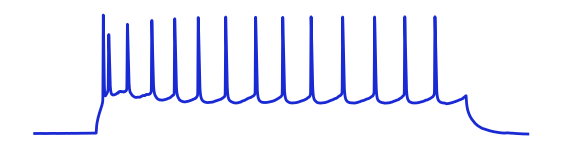

In [24]:
fig, ax_obs = plt.subplots(1, 1, figsize=(7, 1.7))
# Experimental observation
ax_obs.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
sns.despine(left=True, bottom=True, ax=ax_obs)
ax_obs.set_xticks([])
ax_obs.set_yticks([])
plt.savefig(
    "preliminary/observation_example.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [25]:
# load prior simulations
theta = np.load("../code/save_sims/M1_chunks/full_batch.npz")["theta"]
stats = np.load("../code/save_sims/M1_chunks/full_batch.npz")["stats"]
keeping = (~np.isnan(np.mean(stats, axis=1))) & (
    ~np.isinf(np.mean(stats, axis=1))
)  # delete non-spiking simulations
stats = stats[keeping, :]
theta = theta[keeping, :]

In [62]:
# load prior simulations from model without rSS parameter (for suppl figure)
theta_without_rSS = np.load(
    "../code/without_rSS/save_sims/M1_chunks/full_batch_without_rSS.npz"
)["theta"]
stats_without_rSS = np.load(
    "../code/without_rSS/save_sims/M1_chunks/full_batch_without_rSS.npz"
)["stats"]
keeping = (~np.isnan(np.mean(stats_without_rSS, axis=1))) & (
    ~np.isinf(np.mean(stats_without_rSS, axis=1))
)  # delete non-spiking simulations
stats_without_rSS = stats_without_rSS[keeping, :]
theta_without_rSS = theta_without_rSS[keeping, :]

In [26]:
# find 1000 prior simulations closest to the experimental observation in terms of Z-scored ephys distance
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

In [67]:
# same but for model without rSS parameter
s_mean = stats_without_rSS[:, feature_list].mean(axis=0)
s_std = stats_without_rSS[:, feature_list].std(axis=0)
E_distances_without_rSS = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats_without_rSS[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

Next blocks can take a while. If performed once, you don't need to run it again and can just go to loading the saved files.

In [69]:
# Uncomment this block to recompute

# # now do it for all experimental observations
# s_mean=stats[:,feature_list].mean(axis=0)
# s_std=stats[:,feature_list].std(axis=0)
# E_distances_observations=[]
# for i in range(Xo.shape[0]):
#     if i%10==0:
#         print(i,' ', end='')
#     E_distances_one=np.sort(
#         np.sqrt(
#             np.sum(
#                 (
#                     (stats[:,feature_list]-s_mean)/s_std
#                     -(Xo.values[i,feature_list]-s_mean)/s_std
#                 )**2,axis=1
#             )
#         )
#     )[0:1000]
#     E_distances_observations.append(E_distances_one)
# E_distances_observations=np.array(E_distances_observations)
# np.savez('../code/save_sims/E_distances_observations.npz',
#      distances=E_distances_observations
#         )

In [70]:
# Uncomment this block to recompute


# # same but for model without rSS parameter
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_observations=[]
# for i in range(Xo.shape[0]):
#     if i%10==0:
#         print(i,' ', end='')
#     E_distances_one=np.sort(
#         np.sqrt(
#             np.sum(
#                 (
#                     (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                     -(Xo.values[i,feature_list]-s_mean)/s_std
#                 )**2,axis=1
#             )
#         )
#     )[0:1000]
#     E_distances_observations.append(E_distances_one)
# E_distances_observations=np.array(E_distances_observations)
# np.savez('../code/without_rSS/save_sims/E_distances_observations.npz',
#      distances=E_distances_observations
#         )

In [71]:
# Uncomment this block to recompute


# # pick 1000 random prior simulations and perform for each of them an analogous analysis
# selected_random_sims=np.random.randint(0,stats.shape[0],1000)
# stats_picked=stats[selected_random_sims,:]
# E_distances_prior=[]
# for i in range(1000):
#     if i%10==0:
#         print(i,' ', end='')
#     E_distances_prior_one=np.sort(
#         np.sqrt(
#             np.sum(
#                 (
#                     (stats[:,feature_list]-s_mean)/s_std
#                     -(stats_picked[i,feature_list]-s_mean)/s_std
#                 )**2,axis=1
#             )
#         )
#     )[0:1000]
#     E_distances_prior.append(E_distances_prior_one)
# E_distances_prior=np.array(E_distances_prior)
# np.savez('../code/save_sims/E_distances_prior.npz',
#      distances=E_distances_prior,
#      indices=selected_random_sims
#     )

In [27]:
E_distances_prior = np.load("../code/save_sims/E_distances_prior.npz")["distances"]
E_distances_prior_indices = np.load("../code/save_sims/E_distances_prior.npz")[
    "indices"
]
E_distances_observations = np.load("../code/save_sims/E_distances_observations.npz")[
    "distances"
]
E_distances_observations_without_rSS = np.load(
    "../code/without_rSS/save_sims/E_distances_observations.npz"
)["distances"]

In [28]:
from simulator import EphysModel

M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=280,
    save_chunks=True,
)

In [29]:
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_indexes = np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (xo[feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]
x_prior = M1_model._run_HH_model(theta[E_distances_indexes[[1, 500]], :])

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


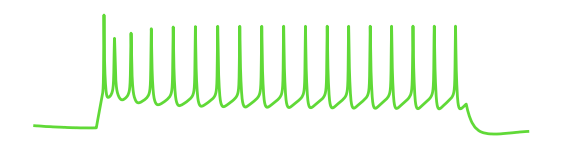

In [30]:
fig, ax_sim = plt.subplots(1, 1, figsize=(7, 1.7))
# Prior simulation
x_prior_example = M1_model._run_HH_model(theta[E_distances_indexes[1], :])
ax_sim.plot(
    x_prior_example["time"], x_prior_example["data"][0, 0, :], c="#60D937", lw=lw
)
sns.despine(left=True, bottom=True, ax=ax_sim)
ax_sim.set_xticks([])
ax_sim.set_yticks([])
plt.savefig(
    "preliminary/very_close_simulation.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [31]:
from without_rSS.simulator import EphysModel

M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=280,
    save_chunks=True,
)

In [ ]:
s_mean = stats_without_rSS[:, feature_list].mean(axis=0)
s_std = stats_without_rSS[:, feature_list].std(axis=0)
E_distances_indexes_without_rSS = np.argsort(
   np.sqrt(
       np.sum(
           (
               (stats_without_rSS[:, feature_list] - s_mean) / s_std
               - (xo[feature_list] - s_mean) / s_std
           )
           ** 2,
           axis=1,
       )
   )
)[0:1000]

x_prior_without_rSS = M1_model._run_HH_model(
   theta_without_rSS[E_distances_indexes_without_rSS[[1, 100, 500]], :]
)

In [31]:
from simulator import EphysModel

M1_model = EphysModel(
    name="M1",
    T=25.0,
    E_Na=69.0,
    E_K=-98.4,
    E_Ca=127.2,
    start=100,
    end=700,
    dt=0.04,
    n_processes=40,
    noise_factor=10,
    use_pathos=True,
    chunk_size=280,
    save_chunks=True,
)

In [32]:
sim_ind_ex = E_distances_prior_indices[
    np.argsort(E_distances_prior[:, -1])[round(E_distances_prior.shape[0] // 2.2)]
]

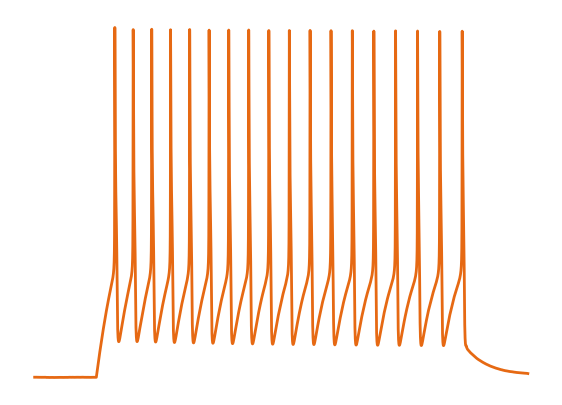

In [33]:
fig, ax_sim = plt.subplots(1, 1, figsize=(7, 5))
# Prior simulation
x_prior_example = M1_model._run_HH_model(theta[sim_ind_ex, :])
ax_sim.plot(
    x_prior_example["time"], x_prior_example["data"][0, 0, :], c="#e66913ff", lw=lw
)
sns.despine(left=True, bottom=True, ax=ax_sim)
ax_sim.set_xticks([])
ax_sim.set_yticks([])
plt.savefig(
    "preliminary/simulation_example.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [34]:
# find 1000 prior simulations closest to a simulation in terms of Z-scored ephys distance
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_ex = np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (stats[sim_ind_ex, feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]

In [35]:
s_mean = stats[:, feature_list].mean(axis=0)
s_std = stats[:, feature_list].std(axis=0)
E_distances_ex_indexes = np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:, feature_list] - s_mean) / s_std
                - (stats[sim_ind_ex, feature_list] - s_mean) / s_std
            )
            ** 2,
            axis=1,
        )
    )
)[0:1000]
x_sim_prior = M1_model._run_HH_model(theta[E_distances_ex_indexes[[1, 500]], :])

In [36]:
x_sim_ex = M1_model._run_HH_model(theta[sim_ind_ex, :])

In [37]:
fancy_colors = (
    np.array(
        [
            [86, 100, 26],
            [192, 175, 251],
            [230, 161, 118],
            [0, 103, 138],
            [152, 68, 100],
            [94, 204, 171],
            [205, 205, 205],
        ]
    )
    / 255
)

In [38]:
def create_figure_4(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 6))
    else:
        fig = fig

    width = 0.23  # for membrane voltage traces
    height = 0.19  # for membrane voltage traces

    ax_schema = plt.axes([-0.2, 0.55, 1.2, 0.47])
    ax_mm_banana = plt.axes([0, 0.15, 0.36, 0.38])

    ax_obs = plt.axes([0.36, 0.37, width, height])
    ax_obs_sim = plt.axes([0.58, 0.37, width, height])
    ax_sim = plt.axes([0.36, 0.17, width, height])
    ax_sim_sim = plt.axes([0.58, 0.15, width, height])

    return ax_schema, ax_mm_banana, ax_obs, ax_obs_sim, ax_sim, ax_sim_sim

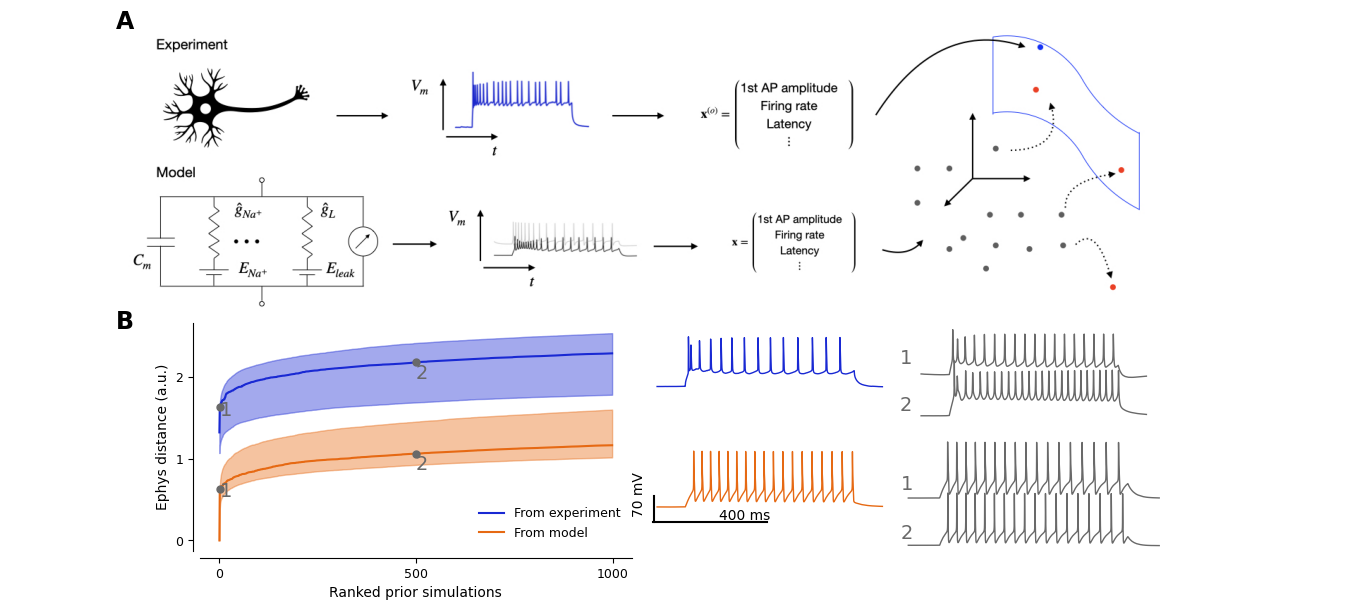

In [40]:
fig = plt.figure(figsize=(12, 6))
ax_schema, ax_mm_banana, ax_obs, ax_obs_sim, ax_sim, ax_sim_sim = create_figure_4(fig)

lw = 1

# Model mismatch, sketch
img_file = os.listdir("sketches/")[0]
img = mpimg.imread("sketches/" + img_file)

ax_schema.imshow(img)
ax_schema.set_xticks([])
ax_schema.set_yticks([])
sns.despine(ax=ax_schema, left=True, bottom=True)

# Model mismatch, banana
ax_mm_banana.plot(range(1000), E_distances, c="#1929d3ff", label="From experiment")
ax_mm_banana.plot(E_distances_ex, c="#e66913ff", label="From model")
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_prior, 30, axis=0),
    np.percentile(E_distances_prior, 70, axis=0),
    color="#e66913ff",
    alpha=0.4,
)
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations, 30, axis=0),
    np.percentile(E_distances_observations, 70, axis=0),
    color="#1929d3ff",
    alpha=0.4,
)

ax_mm_banana.plot([1], [E_distances[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([500], [E_distances[500]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([1], [E_distances_ex[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot(
    [500], [E_distances_ex[500]], color="dimgray", marker=".", markersize=10
)

ax_mm_banana.annotate("1", (1, E_distances[1] - 0.1), color="dimgray", fontsize=14)
ax_mm_banana.annotate("2", (500, E_distances[500] - 0.2), color="dimgray", fontsize=14)
ax_mm_banana.annotate("1", (1, E_distances_ex[1] - 0.1), color="dimgray", fontsize=14)

ax_mm_banana.annotate(
    "2", (500, E_distances_ex[500] - 0.2), color="dimgray", fontsize=14
)
ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=10)
ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=10)

ax_mm_banana.set_xticks([0, 500, 1000])
ax_mm_banana.set_yticks([0, 1, 2])
ax_mm_banana.tick_params(axis="both", which="major", labelsize=9)

ax_mm_banana.legend(loc="lower right", fontsize=9, frameon=False)

adjust_spines(ax_mm_banana, spines=["bottom", "left"])

# Experimental observation and prior simulations close to it
ax_obs.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_obs.set_ylim([ax_obs.get_ylim()[0] - 70, ax_obs.get_ylim()[1] + 70])
ax_obs.set_xlim([ax_obs.get_xlim()[0] - 50, ax_obs.get_xlim()[1] + 50])

ax_obs.set_xticks([])
ax_obs.set_yticks([])
sns.despine(ax=ax_obs, bottom=True, left=True)


ax_obs_sim.plot(x_prior["time"], x_prior["data"][0, 0, :] + 20, lw=lw, color="dimgray")
ax_obs_sim.plot(x_prior["time"], x_prior["data"][1, 0, :] - 60, lw=lw, color="dimgray")

ax_obs_sim.set_xlim([ax_obs.get_xlim()[0], ax_obs.get_xlim()[1]])
ax_obs_sim.set_ylim([ax_obs.get_ylim()[0], ax_obs.get_ylim()[1]])
ax_obs_sim.annotate(
    1,
    (ax_obs.get_xlim()[0] + 15, ax_obs.get_ylim()[1] - 140),
    fontsize=14,
    c="dimgray",
)
ax_obs_sim.annotate(
    2,
    (ax_obs.get_xlim()[0] + 15, ax_obs.get_ylim()[1] - 250),
    fontsize=14,
    c="dimgray",
)
ax_obs_sim.set_xticks([])
ax_obs_sim.set_yticks([])
sns.despine(ax=ax_obs_sim, bottom=True, left=True)


# Prior simulation and prior simulations close to it
ax_sim.plot(x_sim_ex["time"], x_sim_ex["data"][0, 0, :], c="#e66913ff", lw=lw)
ax_sim.set_ylim([ax_obs.get_ylim()[0] - 20, ax_obs.get_ylim()[1] + 20])
ax_sim.set_xlim([ax_obs.get_xlim()[0], ax_obs.get_xlim()[1]])
ax_sim.set_xticks([])
ax_sim.set_yticks([])
sns.despine(ax=ax_sim, bottom=True, left=True)


ax_sim_sim.plot(
    x_sim_prior["time"], x_sim_prior["data"][0, 0, :] + 20, lw=lw, color="dimgray"
)
ax_sim_sim.plot(
    x_sim_prior["time"], x_sim_prior["data"][1, 0, :] - 110, lw=lw, color="dimgray"
)
ax_sim_sim.set_xlim([ax_sim_sim.get_xlim()[0], ax_sim_sim.get_xlim()[1]])
ax_sim_sim.set_ylim([ax_sim_sim.get_ylim()[0], ax_sim_sim.get_ylim()[1]])
ax_sim_sim.annotate(
    1,
    (ax_sim_sim.get_xlim()[0] + 15, ax_sim_sim.get_ylim()[1] - 140),
    fontsize=14,
    c="dimgray",
)
ax_sim_sim.annotate(
    2,
    (ax_sim_sim.get_xlim()[0] + 15, ax_sim_sim.get_ylim()[1] - 270),
    fontsize=14,
    c="dimgray",
)
ax_sim_sim.set_xticks([])
ax_sim_sim.set_yticks([])
sns.despine(ax=ax_sim_sim, bottom=True, left=True)

ax_sim.plot([-15, 390], [-140, -140], "k")
ax_sim.annotate("400 ms", (220, -135))
ax_sim.plot([-10, -10], [-140, -70], "k")
ax_sim.annotate("70 mV", (-89, -120), rotation=90)

fig.text(-0.07, 1.02, "A", fontsize=17, fontweight="bold")
fig.text(-0.07, 0.52, "B", fontsize=17, fontweight="bold")

plt.savefig("figure_4.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_4.pdf", bbox_inches="tight", pad_inches=0)

In [41]:
def create_suppl_figure_1(fig):
    # Suppl. Fig. 1: illustrate model mismatch including a model for which we don't introduce rSS

    if fig is None:
        fig = plt.figure(figsize=(14, 12))
    else:
        fig = fig

    width = 0.14  # for membrane voltage traces
    height = 0.22  # for membrane voltage traces
    ax_mm_banana = plt.axes([0, 0.15, 0.36, 0.8])
    axes_ex_1 = np.array(
        [plt.axes([x, 0.7, width, height]) for x in [0.41, 0.56, 0.71, 0.86]]
    )
    axes_ex_2 = np.array(
        [plt.axes([x, 0.4, width, height]) for x in [0.41, 0.56, 0.71, 0.86]]
    )
    axes_ex_3 = np.array(
        [plt.axes([x, 0.1, width, height]) for x in [0.41, 0.56, 0.71, 0.86]]
    )

    return ax_mm_banana, axes_ex_1, axes_ex_2, axes_ex_3

Text(-89, -120, '70 mV')

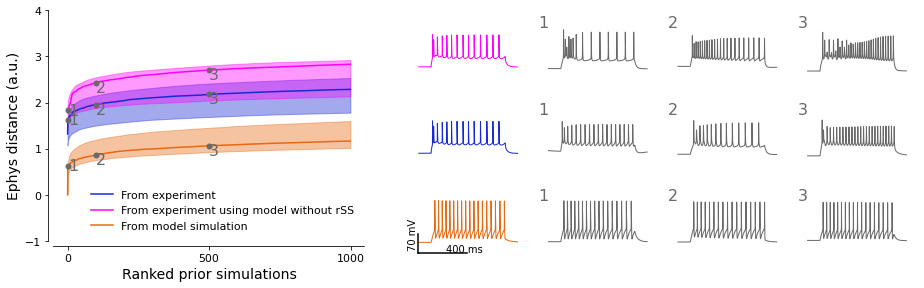

In [43]:
fig = plt.figure(figsize=(12, 4))
ax_mm_banana, axes_ex_1, axes_ex_2, axes_ex_3 = create_suppl_figure_1(fig)

lw = 1


# Model mismatch, banana
ax_mm_banana.plot(range(1000), E_distances, c="#1929d3ff", label="From experiment")
ax_mm_banana.plot(
    range(1000),
    E_distances_without_rSS,
    c="magenta",
    label="From experiment using model without rSS",
)
ax_mm_banana.plot(E_distances_ex, c="#e66913ff", label="From model simulation")
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_prior, 30, axis=0),
    np.percentile(E_distances_prior, 70, axis=0),
    color="#e66913ff",
    alpha=0.4,
)
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations, 30, axis=0),
    np.percentile(E_distances_observations, 70, axis=0),
    color="#1929d3ff",
    alpha=0.4,
)

ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations_without_rSS, 30, axis=0),
    np.percentile(E_distances_observations_without_rSS, 70, axis=0),
    color="magenta",
    alpha=0.4,
)

ax_mm_banana.plot([1], [E_distances[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([100], [E_distances[100]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot([500], [E_distances[500]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot(
    [1], [E_distances_without_rSS[1]], color="dimgray", marker=".", markersize=10
)
ax_mm_banana.plot(
    [100], [E_distances_without_rSS[100]], color="dimgray", marker=".", markersize=10
)
ax_mm_banana.plot(
    [500], [E_distances_without_rSS[500]], color="dimgray", marker=".", markersize=10
)
ax_mm_banana.plot([1], [E_distances_ex[1]], color="dimgray", marker=".", markersize=10)
ax_mm_banana.plot(
    [100], [E_distances_ex[100]], color="dimgray", marker=".", markersize=10
)
ax_mm_banana.plot(
    [500], [E_distances_ex[500]], color="dimgray", marker=".", markersize=10
)


ax_mm_banana.annotate("1", (1, E_distances[1] - 0.1), color="dimgray", fontsize=16)
ax_mm_banana.annotate("2", (100, E_distances[100] - 0.2), color="dimgray", fontsize=16)
ax_mm_banana.annotate("3", (500, E_distances[500] - 0.2), color="dimgray", fontsize=16)
ax_mm_banana.annotate(
    "1", (1, E_distances_without_rSS[1] - 0.1), color="dimgray", fontsize=16
)
ax_mm_banana.annotate(
    "2", (100, E_distances_without_rSS[100] - 0.2), color="dimgray", fontsize=16
)
ax_mm_banana.annotate(
    "3", (500, E_distances_without_rSS[500] - 0.2), color="dimgray", fontsize=16
)
ax_mm_banana.annotate("1", (1, E_distances_ex[1] - 0.1), color="dimgray", fontsize=16)
ax_mm_banana.annotate(
    "2", (100, E_distances_ex[100] - 0.2), color="dimgray", fontsize=16
)
ax_mm_banana.annotate(
    "3", (500, E_distances_ex[500] - 0.2), color="dimgray", fontsize=16
)
ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=14)
ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=14)

ax_mm_banana.set_xticks([0, 500, 1000])
ax_mm_banana.set_yticks([-1, 0, 1, 2, 3, 4])
ax_mm_banana.tick_params(axis="both", which="major", labelsize=11)

ax_mm_banana.legend(loc="lower right", fontsize=11, frameon=False)

adjust_spines(ax_mm_banana, spines=["bottom", "left"])

# Experimental observation and prior simulations close to it, from model without rSS
axes_ex_1[0].plot(observation["time"], observation["data"], c="magenta", lw=lw)
axes_ex_1[0].set_ylim(
    [axes_ex_1[0].get_ylim()[0] - 50, axes_ex_1[0].get_ylim()[1] + 50]
)
axes_ex_1[0].set_xlim(
    [axes_ex_1[0].get_xlim()[0] - 50, axes_ex_1[0].get_xlim()[1] + 50]
)
# axes_ex_1[0].set_title('Experimental observation', fontsize=16)
axes_ex_1[0].set_xticks([])
axes_ex_1[0].set_yticks([])
sns.despine(ax=axes_ex_1[0], bottom=True, left=True)


for i, ax in enumerate(axes_ex_1[1:]):
    ax.plot(
        x_prior_without_rSS["time"],
        x_prior_without_rSS["data"][i, 0, :],
        lw=lw,
        color="dimgray",
    )
    # ToDo NEED THIS ??
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(
        i + 1, (ax.get_xlim()[0] + 10, ax.get_ylim()[1] - 30), fontsize=16, c="dimgray"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)


# Experimental observation and prior simulations close to it
axes_ex_2[0].plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
axes_ex_2[0].set_ylim(
    [axes_ex_2[0].get_ylim()[0] - 50, axes_ex_2[0].get_ylim()[1] + 50]
)
axes_ex_2[0].set_xlim(
    [axes_ex_2[0].get_xlim()[0] - 50, axes_ex_2[0].get_xlim()[1] + 50]
)
# axes_ex_1[0].set_title('Experimental observation', fontsize=16)
axes_ex_2[0].set_xticks([])
axes_ex_2[0].set_yticks([])
sns.despine(ax=axes_ex_2[0], bottom=True, left=True)


for i, ax in enumerate(axes_ex_2[1:]):
    ax.plot(x_prior["time"], x_prior["data"][i, 0, :], lw=lw, color="dimgray")
    # ToDo NEED THIS ??
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(
        i + 1, (ax.get_xlim()[0] + 10, ax.get_ylim()[1] - 30), fontsize=16, c="dimgray"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)

# Prior simulation and prior simulations close to it
axes_ex_3[0].plot(x_sim_ex["time"], x_sim_ex["data"][0, 0, :], c="#e66913ff", lw=lw)
axes_ex_3[0].set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
axes_ex_3[0].set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
# axes_ex_2[0].set_title('Model simulation', fontsize=16)
axes_ex_3[0].set_xticks([])
axes_ex_3[0].set_yticks([])
sns.despine(ax=axes_ex_3[0], bottom=True, left=True)

for i, ax in enumerate(axes_ex_3[1:]):
    ax.plot(x_sim_prior["time"], x_sim_prior["data"][i, 0, :], lw=lw, color="dimgray")
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(
        i + 1, (ax.get_xlim()[0] + 10, ax.get_ylim()[1] - 30), fontsize=16, c="dimgray"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)


axes_ex_3[0].plot([-10, 390], [-140, -140], "k")
axes_ex_3[0].annotate("400 ms", (220, -135))
axes_ex_3[0].plot([-10, -10], [-140, -70], "k")
axes_ex_3[0].annotate("70 mV", (-89, -120), rotation=90)

plt.savefig("figure_1_suppl.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_1_suppl.pdf", bbox_inches="tight", pad_inches=0)

### Figure 3

How we overcome model mismatch with neural posterior estimation.

In [41]:
with open("../code/save_posteriors/training_schedule_0.pickle", "rb") as f:
    npe_posterior = pickle.load(f)
with open("../code/save_posteriors/training_schedule_2d.pickle", "rb") as f:
    npep_posterior = pickle.load(f)

Fetch 3 posterior samples with highest posterior weight. Get there corresponding simulations and summary statistics. You can also immediately load the simulations that come with the figure from the GitHub repo and skip this cell.

In [42]:
# Uncomment this block to recompute

# npe_samples=npe_posterior.sample(
#     (10000,),
#     x=torch.as_tensor(xo[feature_list], dtype=float),
# )
# npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
# npep_samples=npep_posterior.sample(
#     (10000,),
#     x=torch.as_tensor(xo[feature_list], dtype=float),
# )
# npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
# x_npe=M1_model._run_HH_model(npe_samples.numpy())
# x_npep=M1_model._run_HH_model(npep_samples.numpy())

# summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
# summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

# fig_1_sims_to_show={
#     'npe':{'samples':npe_samples, 'x':x_npe, 'summ_stats':summ_stats_npe},
#     'npep':{'samples':npep_samples, 'x':x_npep, 'summ_stats':summ_stats_npep}
# }

# with open('../code/save_model_parameters/fig_3_sims_to_show.pickle', 'wb') as f:
#     pickle.dump(fig_1_sims_to_show, f)

In [43]:
with open("../code/save_model_parameters/fig_3_sims_to_show.pickle", "rb") as f:
    fig_3_sims_to_show = pickle.load(f)

In [44]:
npe_samples = fig_3_sims_to_show["npe"]["samples"]
x_npe = fig_3_sims_to_show["npe"]["x"]
summ_stats_npe = fig_3_sims_to_show["npe"]["summ_stats"]

npen_samples = fig_3_sims_to_show["npep"]["samples"]
x_npen = fig_3_sims_to_show["npep"]["x"]
summ_stats_npen = fig_3_sims_to_show["npep"]["summ_stats"]

In [45]:
obs_index = np.where(Xo.index == cell_name)[0][0]

# best_prior_stats = np.load("../code/save_sims/best_1000_Euclidean_sims.npz")["stats"][
#    ::1000, :
# ]
# best_prior_stats_nans = np.isnan(best_prior_stats.sum(axis=1))

Xo_values = Xo.values[:, :-4]
Xo_mean = Xo.values[:, :-4].mean(axis=0)
Xo_std = Xo.values[:, :-4].std(axis=0)


# prior_score = np.sqrt(
#    (
#        (best_prior_stats[obs_index, :] - Xo_mean) / Xo_std
#        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
#    )
#    ** 2
# )

npe_score = np.sqrt(
    ((summ_stats_npe - Xo_mean) / Xo_std - (Xo_values[obs_index, :] - Xo_mean) / Xo_std)
    ** 2
)

npen_score = np.sqrt(
    (
        (summ_stats_npen - Xo_mean) / Xo_std
        - (Xo_values[obs_index, :] - Xo_mean) / Xo_std
    )
    ** 2
)

In [46]:
mpl.rcParams.update({"font.size": 14})

In [47]:
def create_figure_3(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 5))
    else:
        fig = fig

    width, height = 0.04, 0.12
    ax_features = plt.axes([0, 0, 0.12, 1])
    ax_observation = plt.axes([0.02, 0.01, width + 0.15, height + 0.03])
    axes_npe = np.array(
        [
            [
                plt.axes([0.15 + x, y, width, height])
                for x in [0, 0.06, 0.12, 0.18, 0.24, 0.3, 0.36]
            ]
            for y in [0.86, 0.72, 0.58, 0.44, 0.3, 0.16, 0.02]
        ]
    )

    ax_npe_s1 = plt.axes([0.13, 0.3, width + 0.15, height + 0.03])
    ax_npe_s2 = plt.axes([0.18, 0.15, width + 0.15, height + 0.03])
    ax_npe_s3 = plt.axes([0.23, 0, width + 0.15, height + 0.03])

    axes_npep = np.array(
        [
            [
                plt.axes([0.58 + x, y, width, height])
                for x in [0, 0.06, 0.12, 0.18, 0.24, 0.3, 0.36]
            ]
            for y in [0.86, 0.72, 0.58, 0.44, 0.3, 0.16, 0.02]
        ]
    )

    ax_npep_s1 = plt.axes([0.56, 0.3, width + 0.15, height + 0.03])
    ax_npep_s2 = plt.axes([0.61, 0.15, width + 0.15, height + 0.03])
    ax_npep_s3 = plt.axes([0.66, 0, width + 0.15, height + 0.03])

    return [
        ax_features,
        ax_observation,
        axes_npe,
        axes_npep,
        ax_npe_s1,
        ax_npe_s2,
        ax_npe_s3,
        ax_npep_s1,
        ax_npep_s2,
        ax_npep_s3,
    ]

WARNING    /var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_2325/224730448.py:50: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_offdiag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  pairplot(
 [py.warnings]
WARNING    /var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_2325/224730448.py:76: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_offdiag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  pairplot(
 [py.warnings]


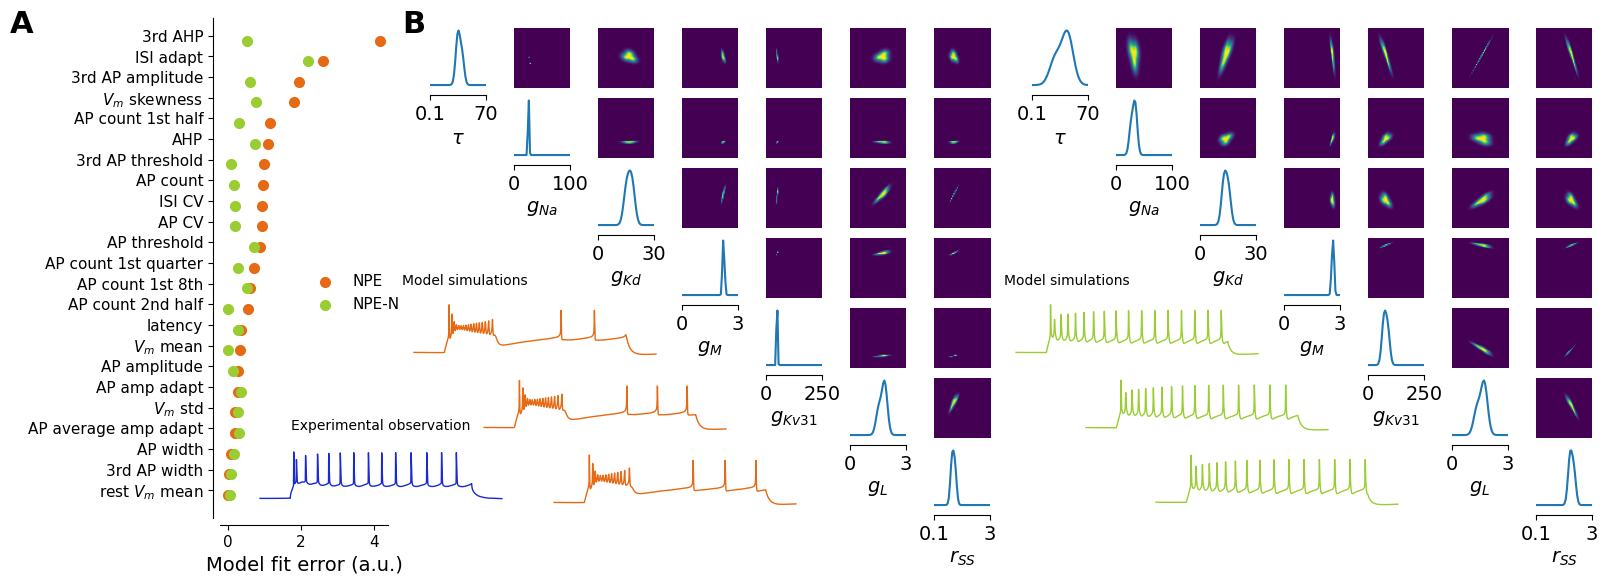

In [49]:
dims_to_show = [2, 4, 5, 6, 7, 8, 12]

fig = plt.figure(figsize=(14, 5))
ax_list = create_figure_3(fig)

ax_features = ax_list[0]

# Feature-wise performances NPE vs NPE-N
order = np.argsort(npe_score)

ax_features.scatter(
    npe_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="#e66913ff",
    label="NPE",
    lw=2,
)
ax_features.scatter(
    npen_score[order],
    np.linspace(0, 4 * len(ephys_features) + 1, num=len(ephys_features)),
    color="yellowgreen",
    label="NPE-N",
    lw=2,
)
adjust_spines(ax_features, spines=["bottom", "left"])
ax_features.set_yticks(
    np.linspace(1, 4 * len(ephys_features) + 2, num=len(ephys_features))
)
ax_features.legend(loc=(0.5, 0.4), fontsize=11, frameon=False)
ax_features.set_xlabel("Model fit error (a.u.)", fontsize=14)
ax_features.set_yticklabels(ephys_features[order])
ax_features.tick_params(axis="y", which="major", labelsize=11)
ax_features.tick_params(axis="x", which="major", labelsize=11)

ax_observation = ax_list[1]

# Experimental observation
ax_observation.plot(observation["time"], observation["data"], c="#1929d3ff", lw=lw)
ax_observation.set_ylim(
    [ax_observation.get_ylim()[0] - 30, ax_observation.get_ylim()[1] + 30]
)
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)
ax_observation.set_title("Experimental observation", fontsize=10)

axes_npe = ax_list[2]

# npe pairplot
pairplot(
    npe_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=list(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npe,
    upper="kde",
    diag="kde",
)

ax_npe_s1, ax_npe_s2, ax_npe_s3 = ax_list[4], ax_list[5], ax_list[6]

ax_npe_s1.plot(x_npe["time"], x_npe["data"][0, 0, :], lw=lw, color="#e66913ff")
ax_npe_s2.plot(x_npe["time"], x_npe["data"][1, 0, :], lw=lw, color="#e66913ff")
ax_npe_s3.plot(x_npe["time"], x_npe["data"][2, 0, :], lw=lw, color="#e66913ff")

axes_npen = ax_list[3]

# npe-n pairplot
pairplot(
    npen_samples[:, dims_to_show],
    limits=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    ticks=list(
        zip(np.array(prior_min)[dims_to_show], np.array(prior_max)[dims_to_show])
    ),
    labels=list(model_param_names[dims_to_show]),
    points_offdiag={"markersize": 6},
    points_colors="r",
    fig=fig,
    axes=axes_npen,
    upper="kde",
    diag="kde",
)

ax_npen_s1, ax_npen_s2, ax_npen_s3 = ax_list[7], ax_list[8], ax_list[9]

ax_npen_s1.plot(x_npen["time"], x_npen["data"][0, 0, :], lw=lw, color="yellowgreen")
ax_npen_s2.plot(x_npen["time"], x_npen["data"][1, 0, :], lw=lw, color="yellowgreen")
ax_npen_s3.plot(x_npen["time"], x_npen["data"][2, 0, :], lw=lw, color="yellowgreen")

for ax in [ax_npe_s1, ax_npe_s2, ax_npe_s3, ax_npen_s1, ax_npen_s2, ax_npen_s3]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])
    ax.set_xlim([ax_observation.get_xlim()[0], ax_observation.get_xlim()[1]])
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True, left=True)
ax_npe_s1.set_title("Model simulations", fontsize=10, loc="left")
ax_npen_s1.set_title("Model simulations", fontsize=10, loc="left")

fig.text(-0.15, 0.97, "A", fontsize=22, fontweight="bold")
fig.text(0.13, 0.97, "B", fontsize=22, fontweight="bold")

plt.savefig("figure_3.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_3.png", bbox_inches="tight", pad_inches=0)